# Metodología de Preprocesamiento y Modelado

Este notebook sigue una metodología de preprocesamiento rigurosa para garantizar la integridad del modelo y evitar sesgos comunes como el **data leakage**. A continuación, se detallan las decisiones clave adoptadas.

---

### 1. Tratamiento de Valores Nulos como Información.

En lugar de emplear imputación estadística (como la media o mediana), los valores nulos tanto en variables numéricas como categóricas se tratarán como una categoría o valor adicional.

* **Variables Numéricas**: Los `NaN` se imputarán con un valor atípico y constante (`-20`).
* **Variables Categóricas**: Los `NaN` se tratarán como una nueva categoría (ej. "Missing").

**Razón**: Esta estrategia permite que los modelos no lineales, como los basados en árboles, aprendan patrones directamente de la ausencia de un dato. La falta de información puede ser, en sí misma, una señal predictiva importante que la imputación estadística podría ocultar.

---

### 2. Pipeline de Preprocesamiento para Evitar *Data Leakage* 

Los datos preprocesados durante el Análisis Exploratorio de Datos (EDA) **no se utilizarán directamente para el entrenamiento**. Normalizar el conjunto de datos completo antes de dividirlo en entrenamiento y prueba introduciría **data leakage**, ya que el conjunto de entrenamiento "aprendería" información (como la media y la desviación estándar) del conjunto de prueba.

**Solución**: Se ha construido un `Pipeline` de `scikit-learn` independiente. Este pipeline asegura que cada paso del preprocesamiento (imputación, escalado, codificación) se ajuste (`fit`) **únicamente con los datos de entrenamiento** dentro de cada pliegue de la validación cruzada, y luego solo transforme (`transform`) los datos de prueba.

Aunque los modelos no lineales utilizados (XGBoost, Random Forest) no requieren estrictamente una normalización de datos, se incluye un `RobustScaler` con fines ilustrativos y para garantizar la consistencia en el procesamiento.

---

### 3. Omisión de Reducción de Dimensionalidad 

No se aplicarán técnicas de reducción de dimensionalidad (como PCA) por dos motivos principales:

1.  **Bajo Número de Variables**: El conjunto de datos cuenta con pocas variables, por lo que la "maldición de la dimensionalidad" no es una preocupación significativa.
2.  **Preservación de Relaciones No Lineales**: Los modelos no lineales son capaces de capturar interacciones complejas entre las variables originales. Las transformaciones ortogonales de la reducción de dimensionalidad podrían ocultar esta varianza y simplificar en exceso las relaciones, resultando en una pérdida de capacidad predictiva.

In [72]:
# =============================================================================
# 1. IMPORTACIÓN DE LIBRERÍAS
# =============================================================================
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import randint, uniform
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, auc, precision_recall_curve
)
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder, RobustScaler, LabelEncoder, label_binarize
)

In [73]:
# Lectura de datos limpios 
clean_path = "obesity_clean_raw.csv"
df = pd.read_csv(clean_path, sep=None, engine="python", encoding="utf-8")

 ENTRENANDO MODELO: KNN
Fitting 5 folds for each of 50 candidates, totalling 250 fits

---  RESULTADOS ---
Mejores Hiperparámetros para KNN:
{'classifier__metric': 'manhattan', 'classifier__n_neighbors': 3, 'classifier__weights': 'distance'}

Mejor puntaje CV (Accuracy): 0.8610
Precisión final en Test: 0.8612


--- EVALUACIÓN DETALLADA ---
--- Reporte de Clasificación ---
                     precision    recall  f1-score   support

Insufficient_Weight       0.82      0.94      0.88        53
      Normal_Weight       0.69      0.54      0.61        57
     Obesity_Type_I       0.86      0.93      0.89        70
    Obesity_Type_II       1.00      1.00      1.00        60
   Obesity_Type_III       0.98      1.00      0.99        65
 Overweight_Level_I       0.74      0.78      0.76        55
Overweight_Level_II       0.88      0.79      0.84        58

           accuracy                           0.86       418
          macro avg       0.85      0.86      0.85       418
       weight

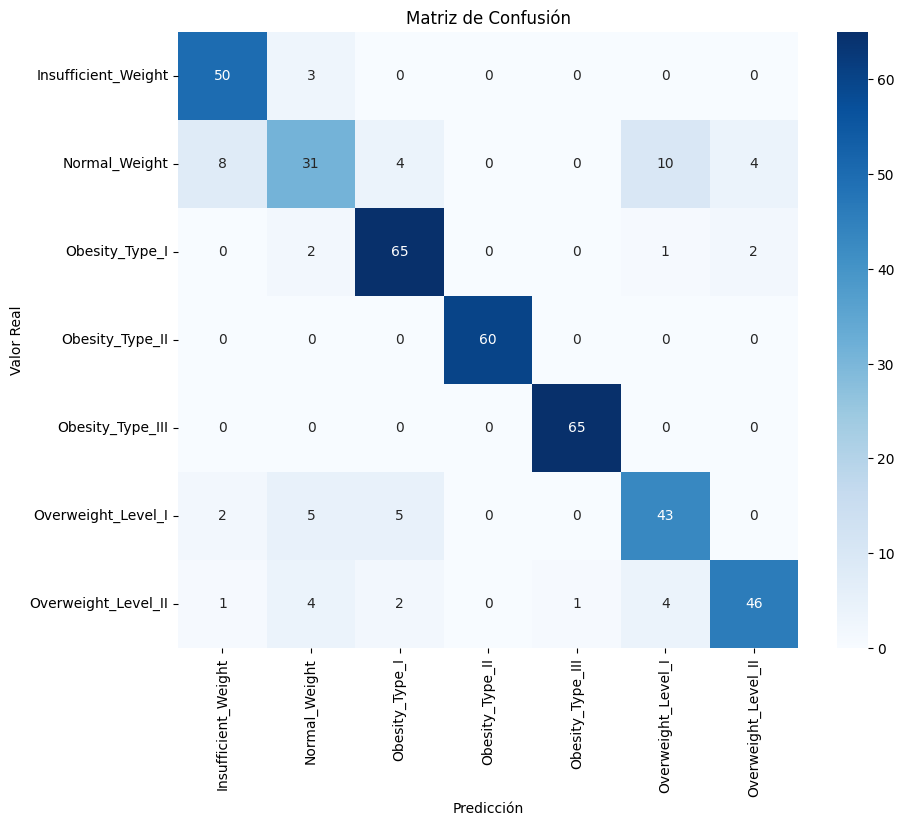


ROC AUC Score (One-vs-Rest): 0.9605


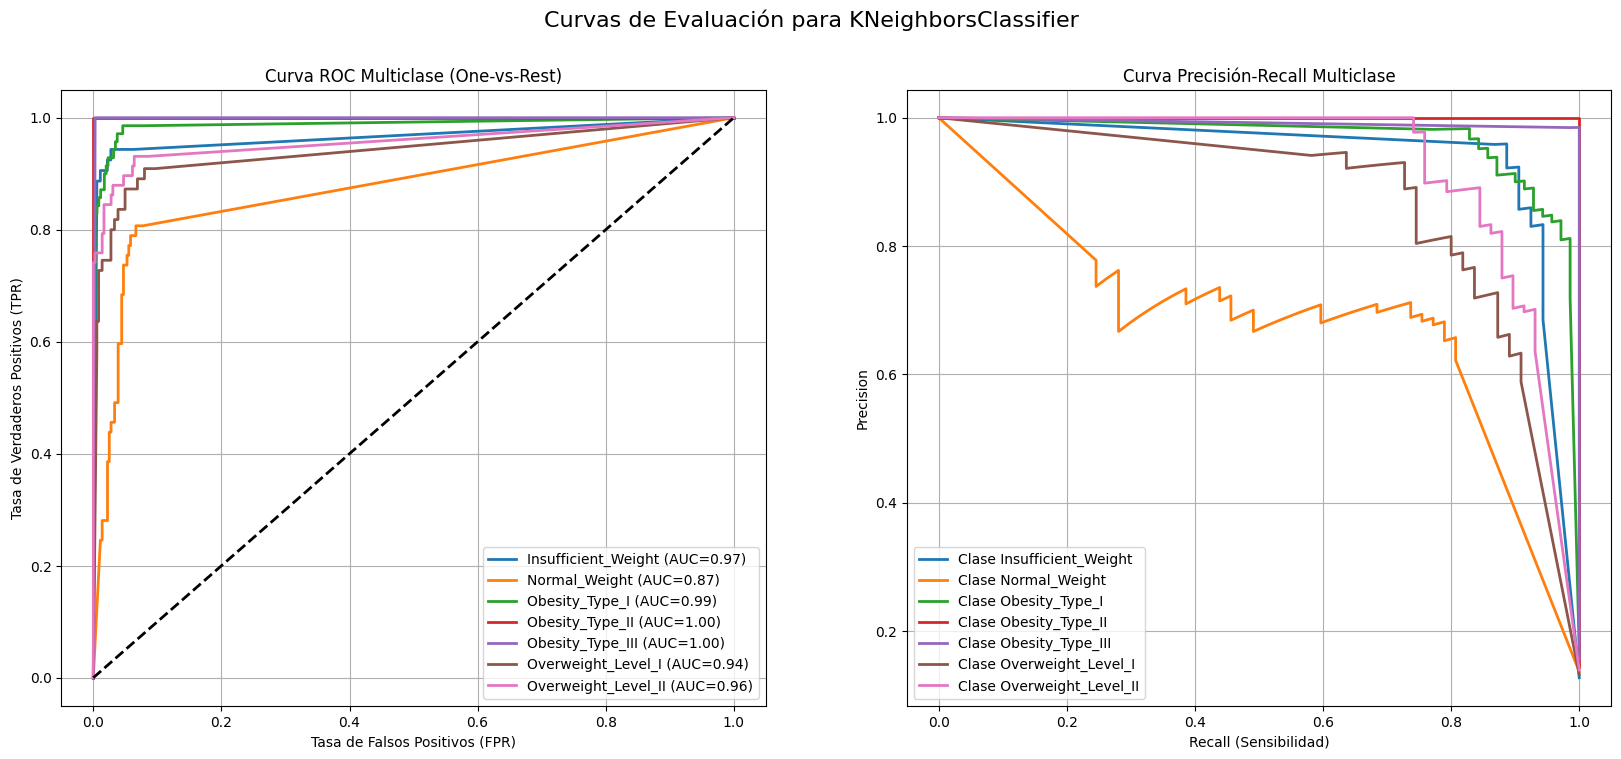


---  INTERPRETACIÓN DEL MODELO ---

El modelo seleccionado (KNN) no tiene 'feature_importances_'.
 ENTRENANDO MODELO: Random Forest
Fitting 5 folds for each of 50 candidates, totalling 250 fits

---  RESULTADOS ---
Mejores Hiperparámetros para Random Forest:
{'classifier__max_depth': 21, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 6, 'classifier__n_estimators': 323}

Mejor puntaje CV (Accuracy): 0.9377
Precisión final en Test: 0.9498


--- EVALUACIÓN DETALLADA ---
--- Reporte de Clasificación ---
                     precision    recall  f1-score   support

Insufficient_Weight       1.00      0.94      0.97        53
      Normal_Weight       0.79      0.95      0.86        57
     Obesity_Type_I       1.00      0.97      0.99        70
    Obesity_Type_II       1.00      1.00      1.00        60
   Obesity_Type_III       1.00      0.98      0.99        65
 Overweight_Level_I       0.91      0.89      0.90        55
Overweigh

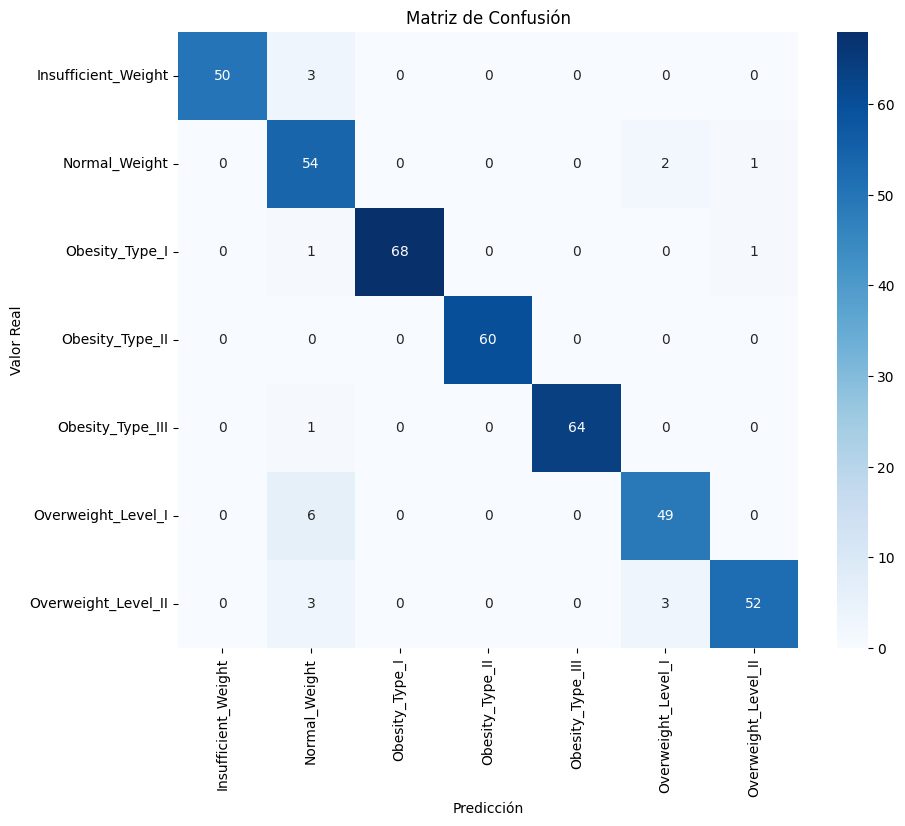


ROC AUC Score (One-vs-Rest): 0.9940


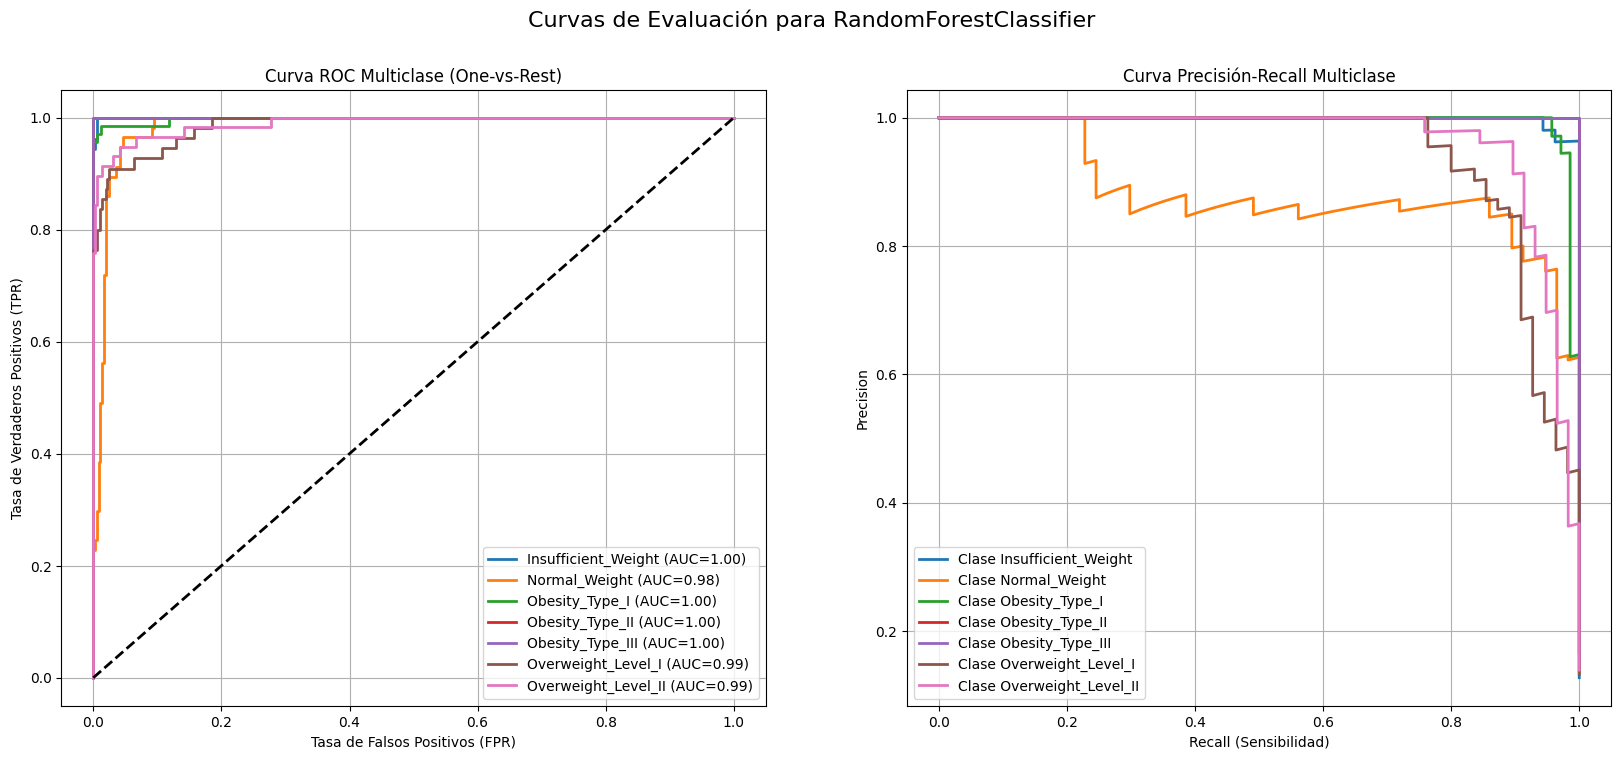


---  INTERPRETACIÓN DEL MODELO ---


C:\Users\user\AppData\Local\Temp\ipykernel_3244\2071174782.py:186: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importances_df.head(20), palette='viridis')


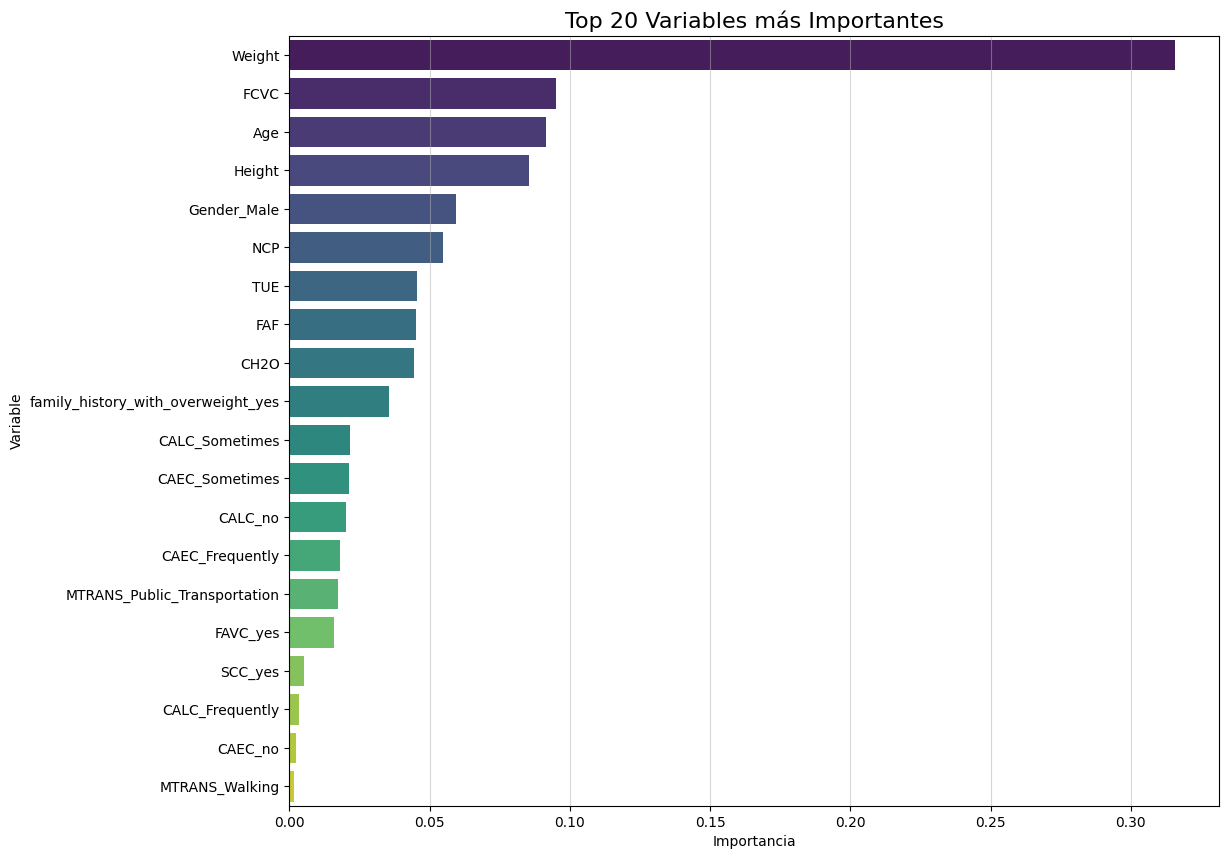

 ENTRENANDO MODELO: XGBoost
Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [16:06:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



---  RESULTADOS ---
Mejores Hiperparámetros para XGBoost:
{'classifier__colsample_bytree': np.float64(0.9022204554172195), 'classifier__learning_rate': np.float64(0.07863944964748673), 'classifier__max_depth': 9, 'classifier__n_estimators': 286, 'classifier__subsample': np.float64(0.8779139732158818)}

Mejor puntaje CV (Accuracy): 0.9665
Precisión final en Test: 0.9713


--- EVALUACIÓN DETALLADA ---
--- Reporte de Clasificación ---
                     precision    recall  f1-score   support

Insufficient_Weight       1.00      1.00      1.00        53
      Normal_Weight       0.92      0.96      0.94        57
     Obesity_Type_I       1.00      0.97      0.99        70
    Obesity_Type_II       0.97      1.00      0.98        60
   Obesity_Type_III       1.00      0.98      0.99        65
 Overweight_Level_I       0.96      0.89      0.92        55
Overweight_Level_II       0.95      0.98      0.97        58

           accuracy                           0.97       418
          ma

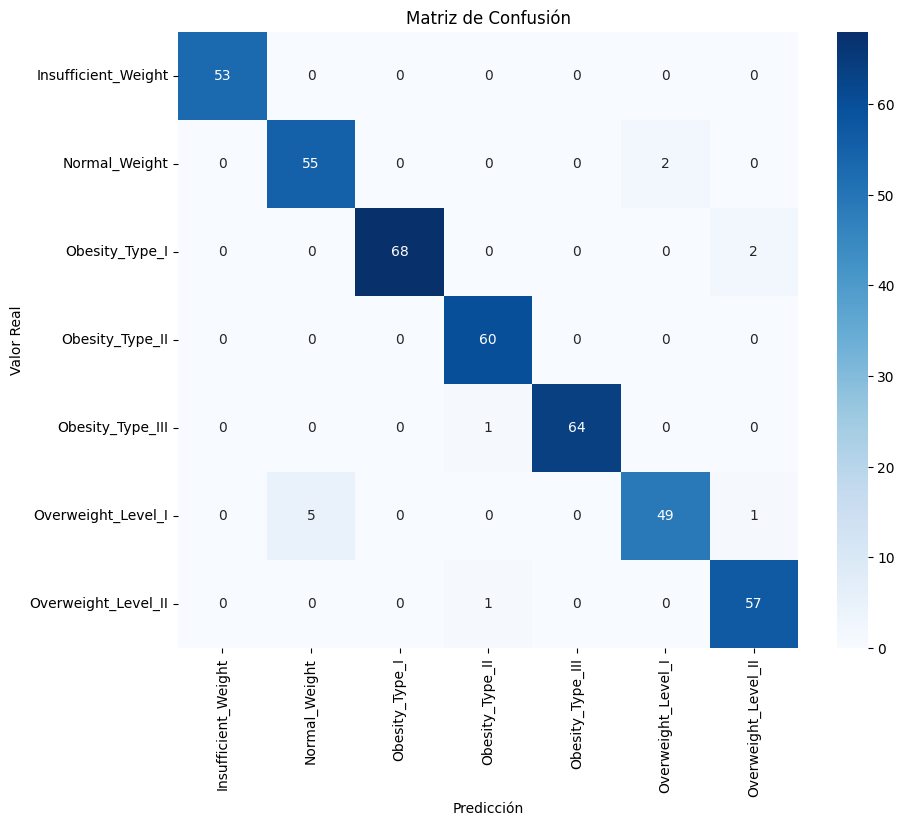


ROC AUC Score (One-vs-Rest): 0.9993


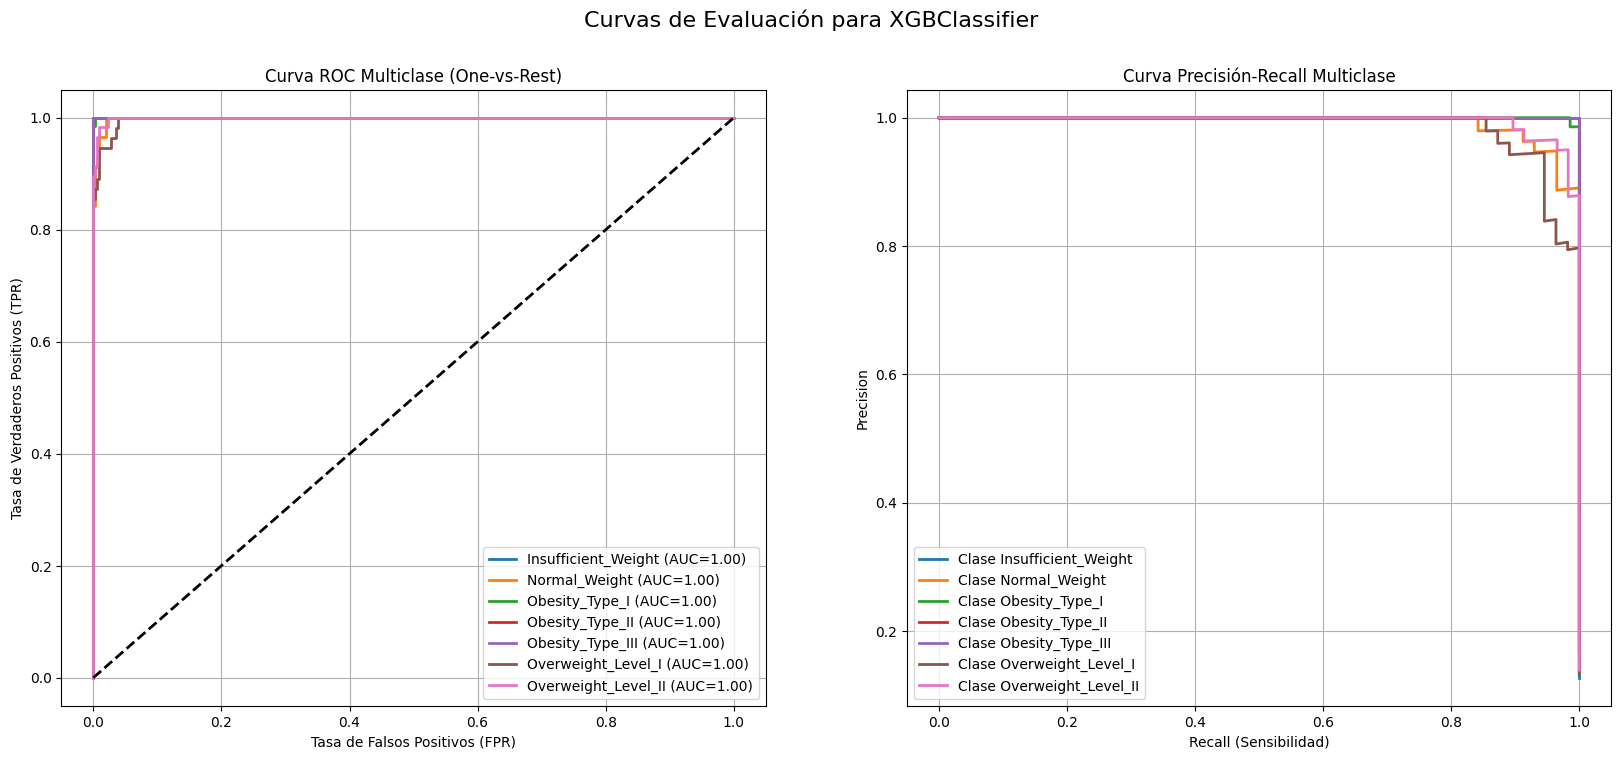


---  INTERPRETACIÓN DEL MODELO ---


C:\Users\user\AppData\Local\Temp\ipykernel_3244\2071174782.py:186: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importances_df.head(20), palette='viridis')


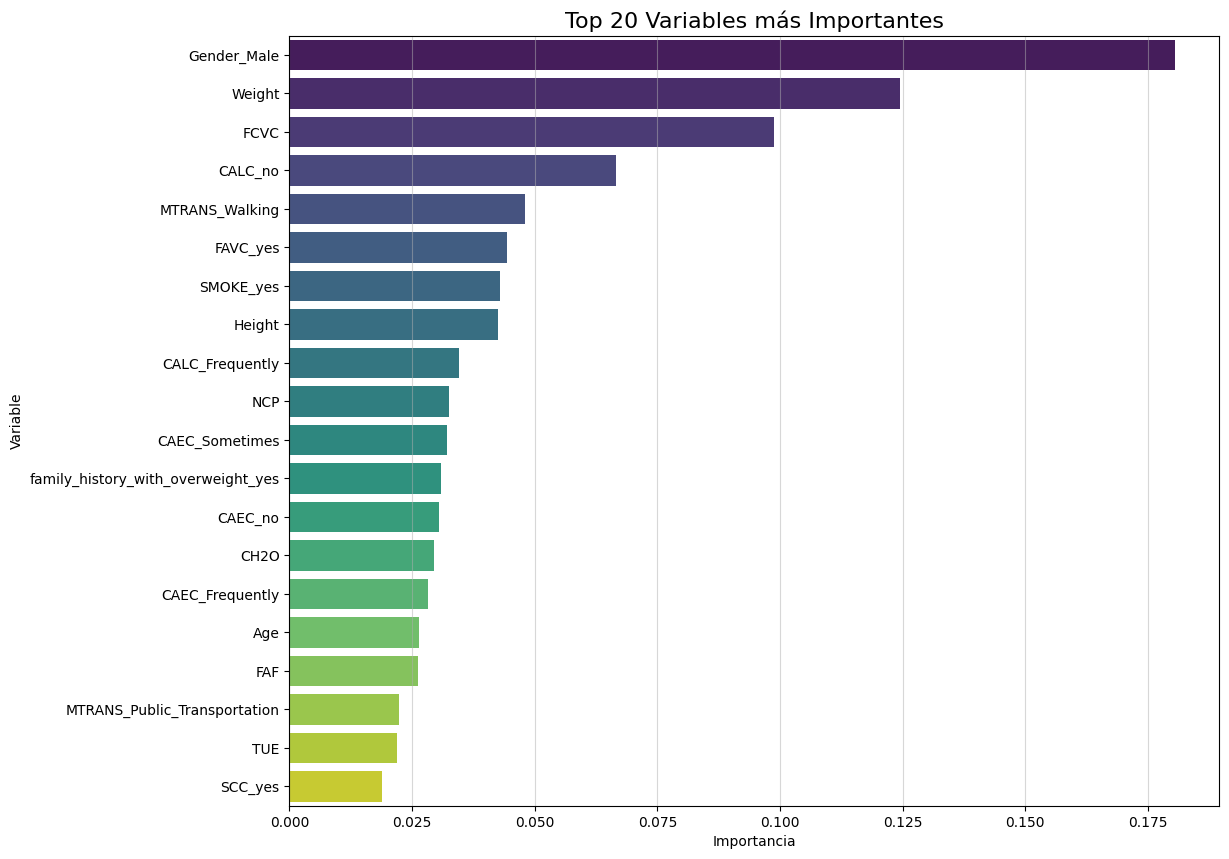

Interpretacion adicional de la interaccion entre las variables y los resultados del modelo.

--- Generando Curvas de Dependencia Parcial para: ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'] ---


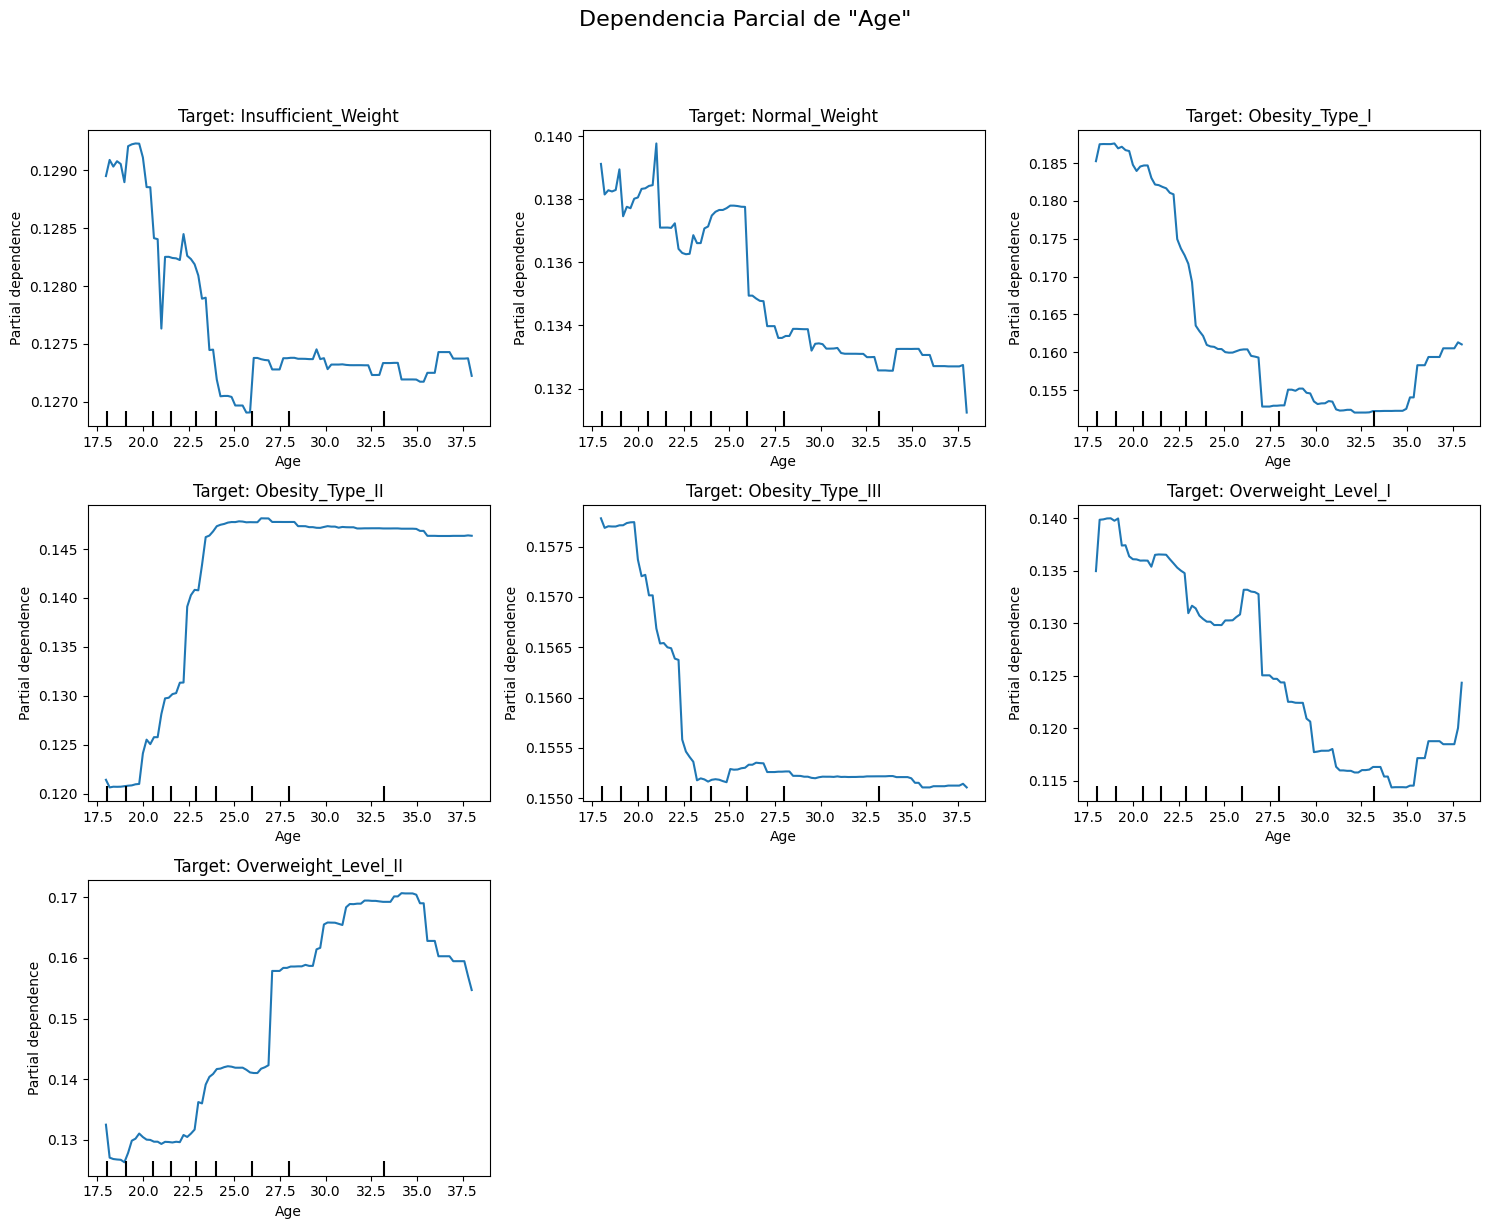

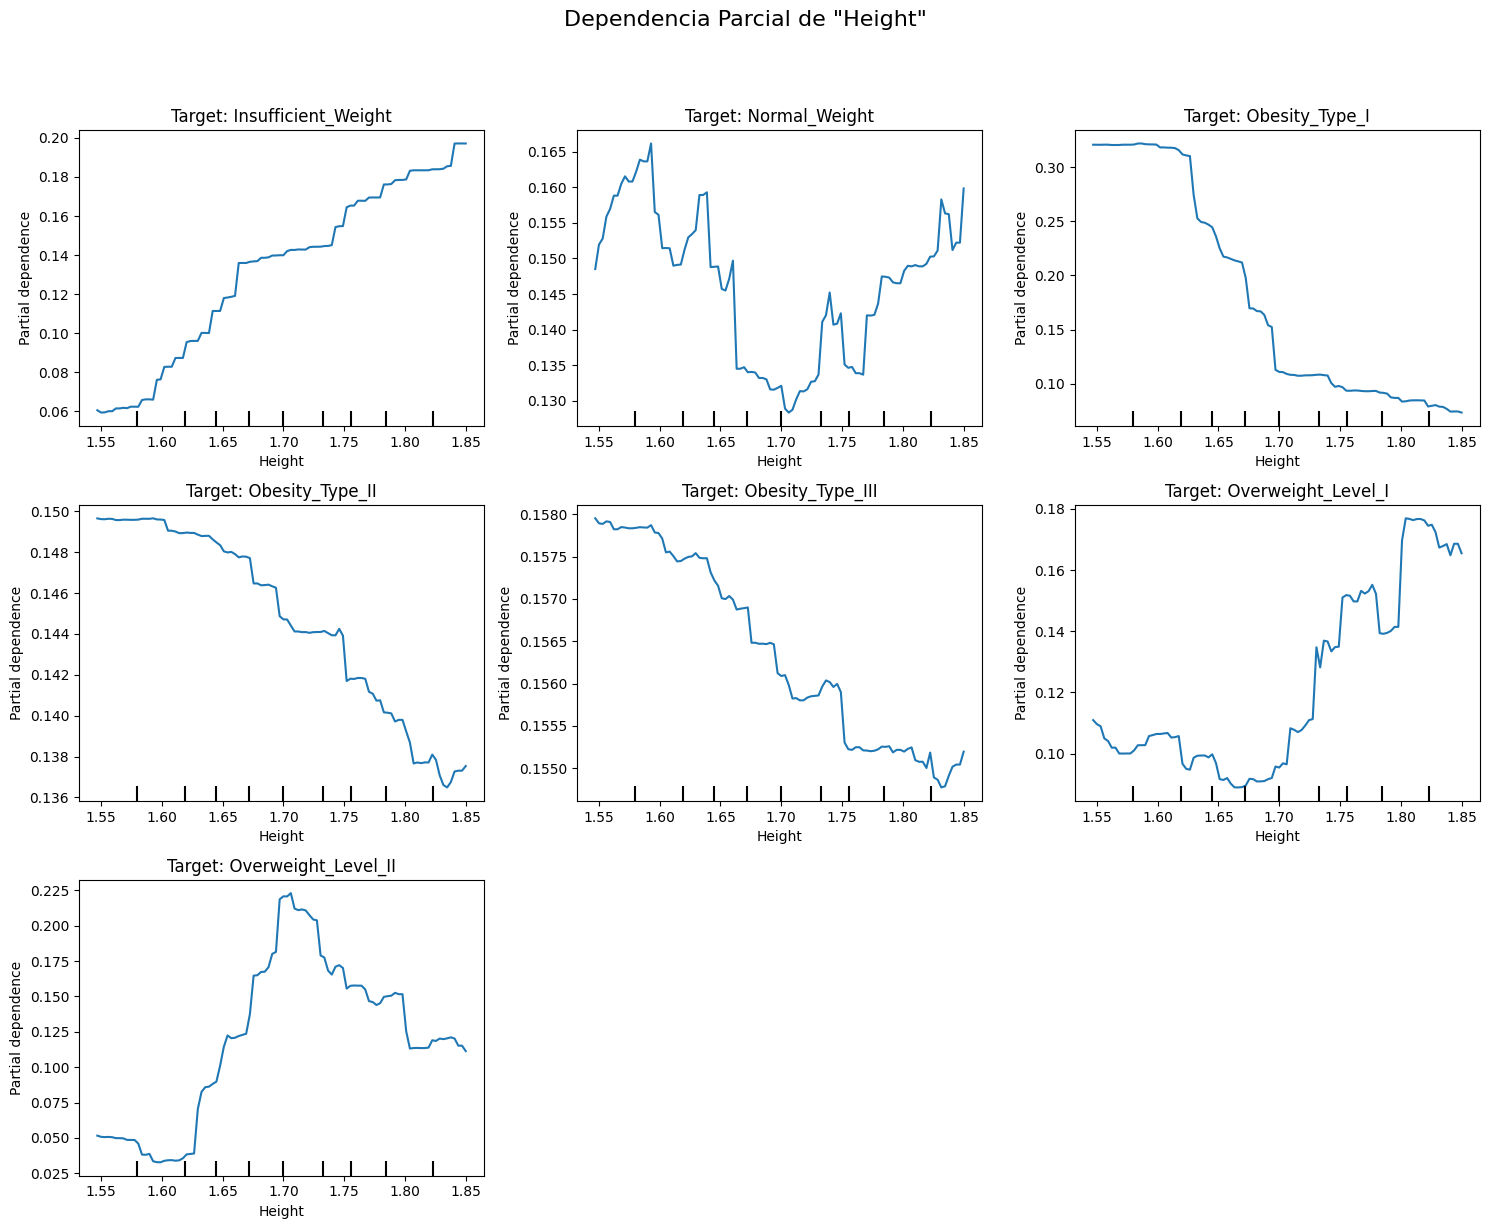

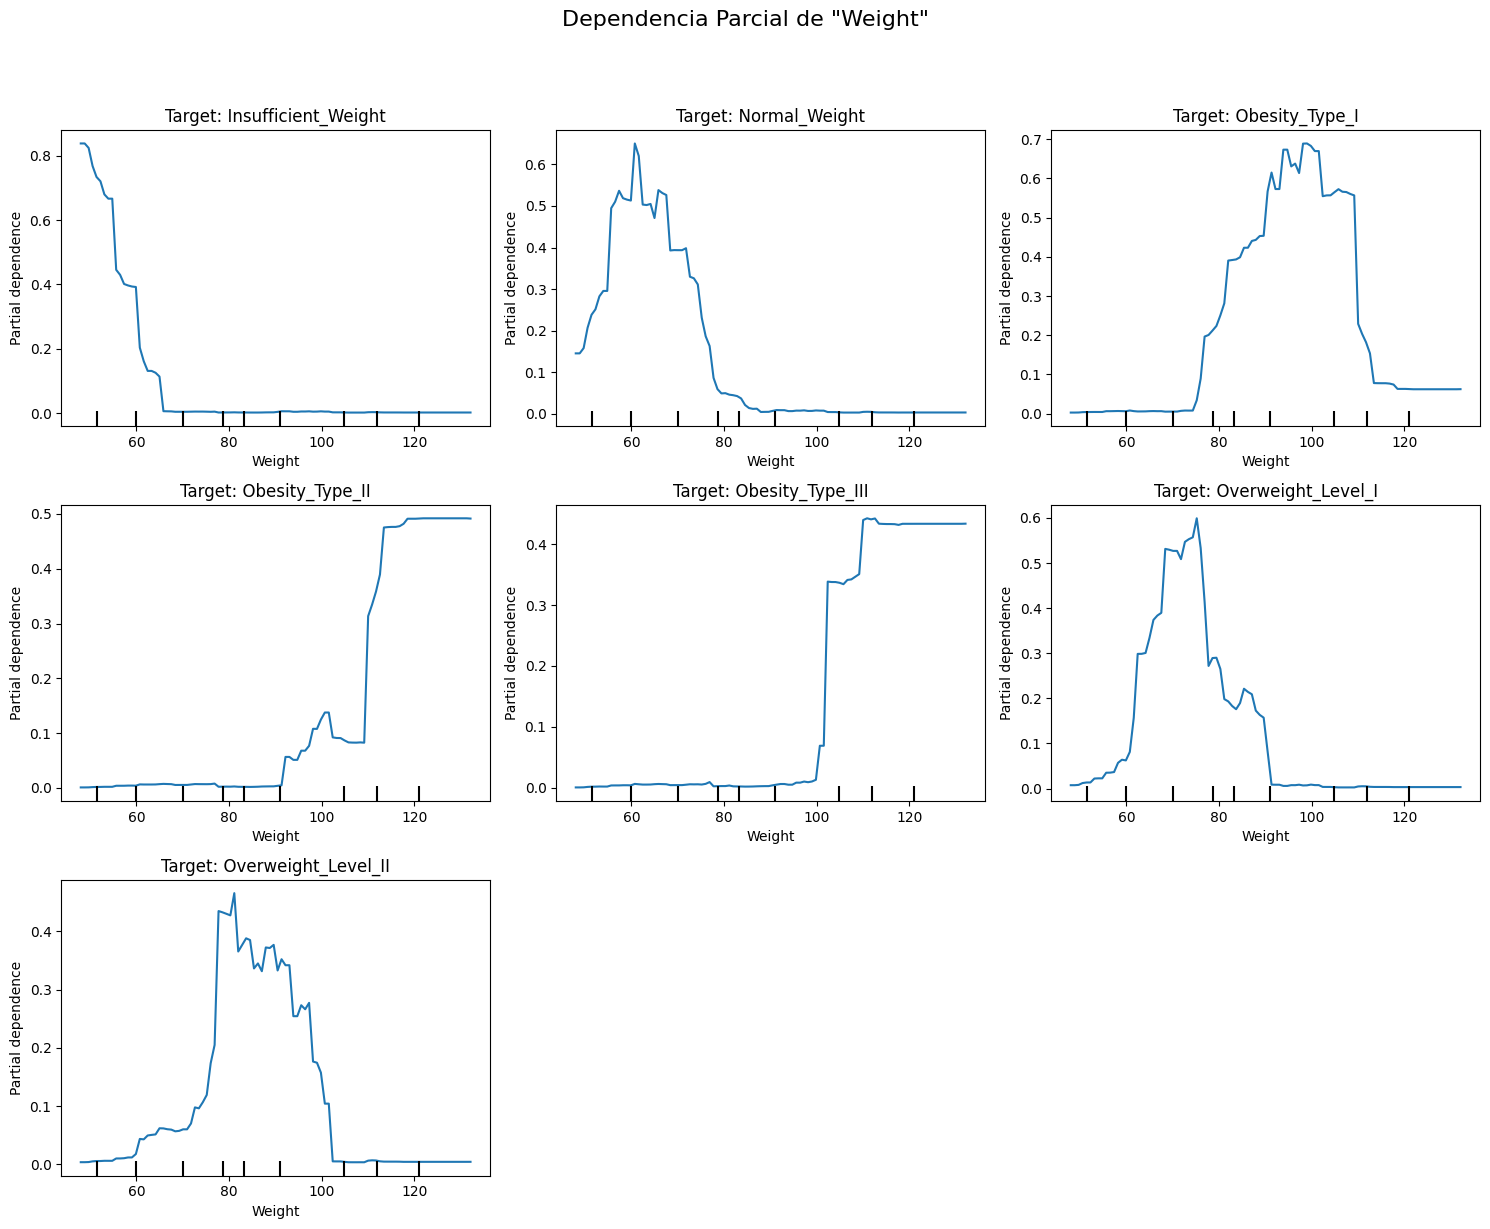

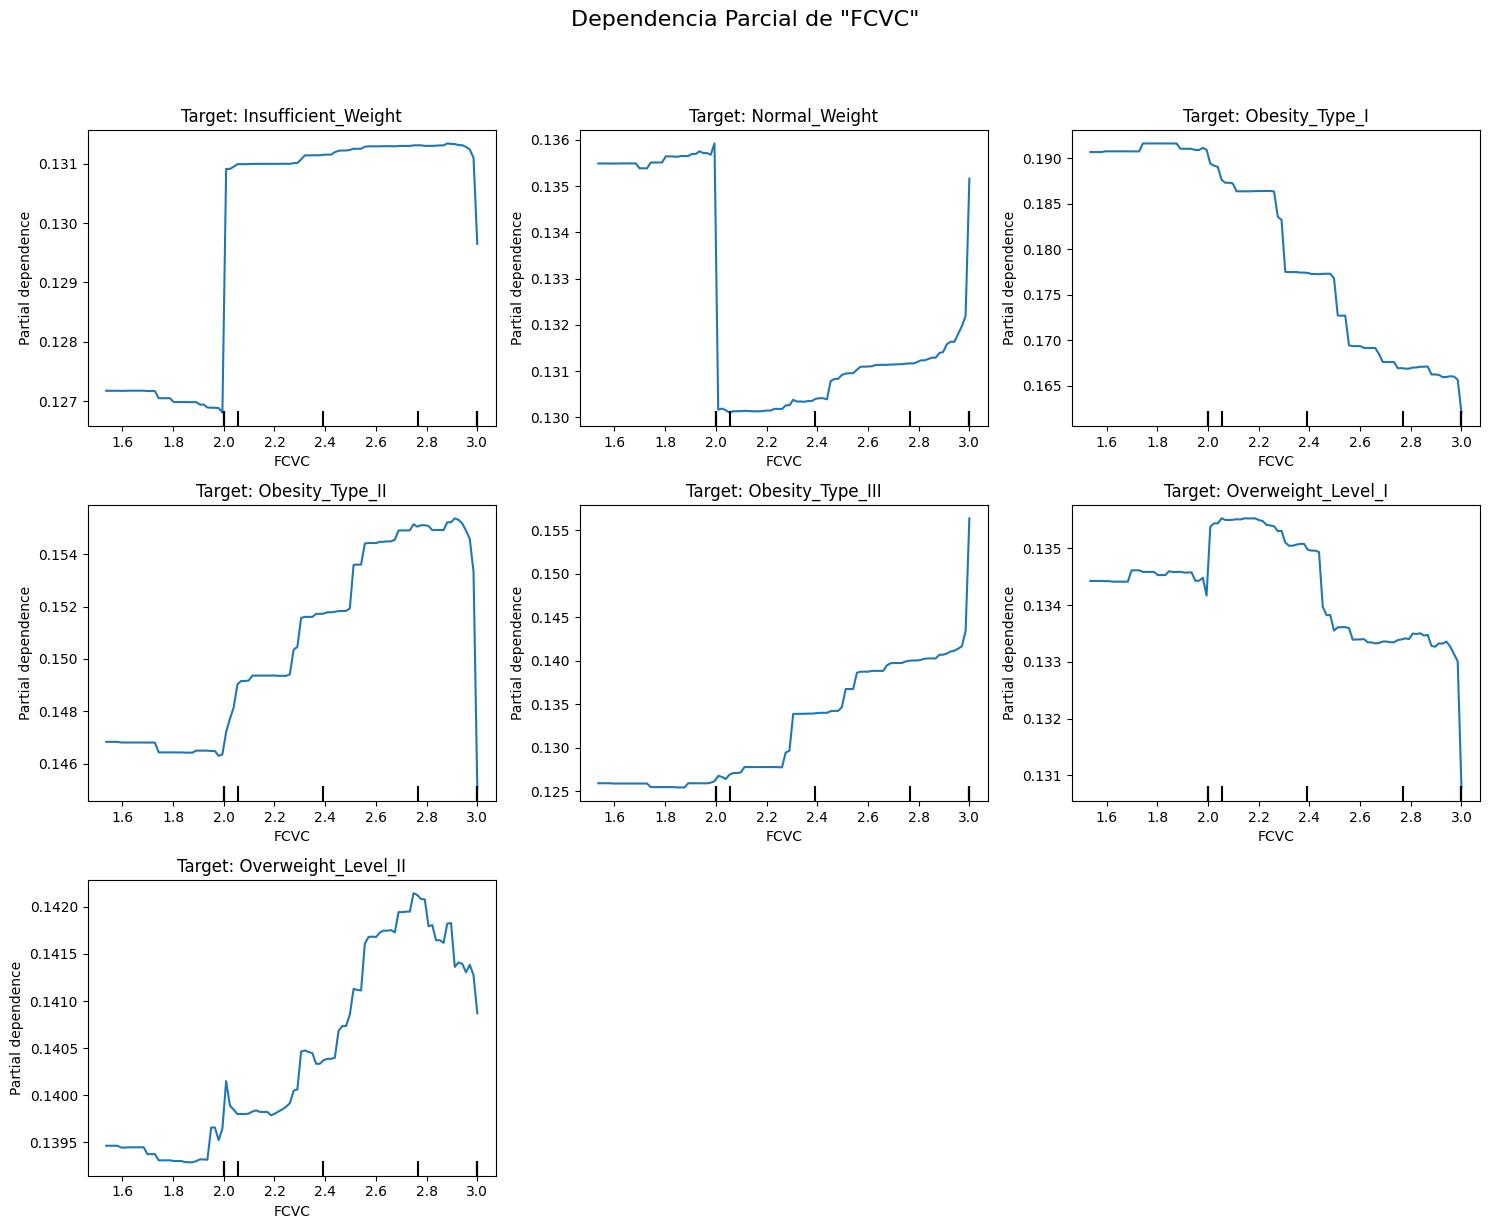

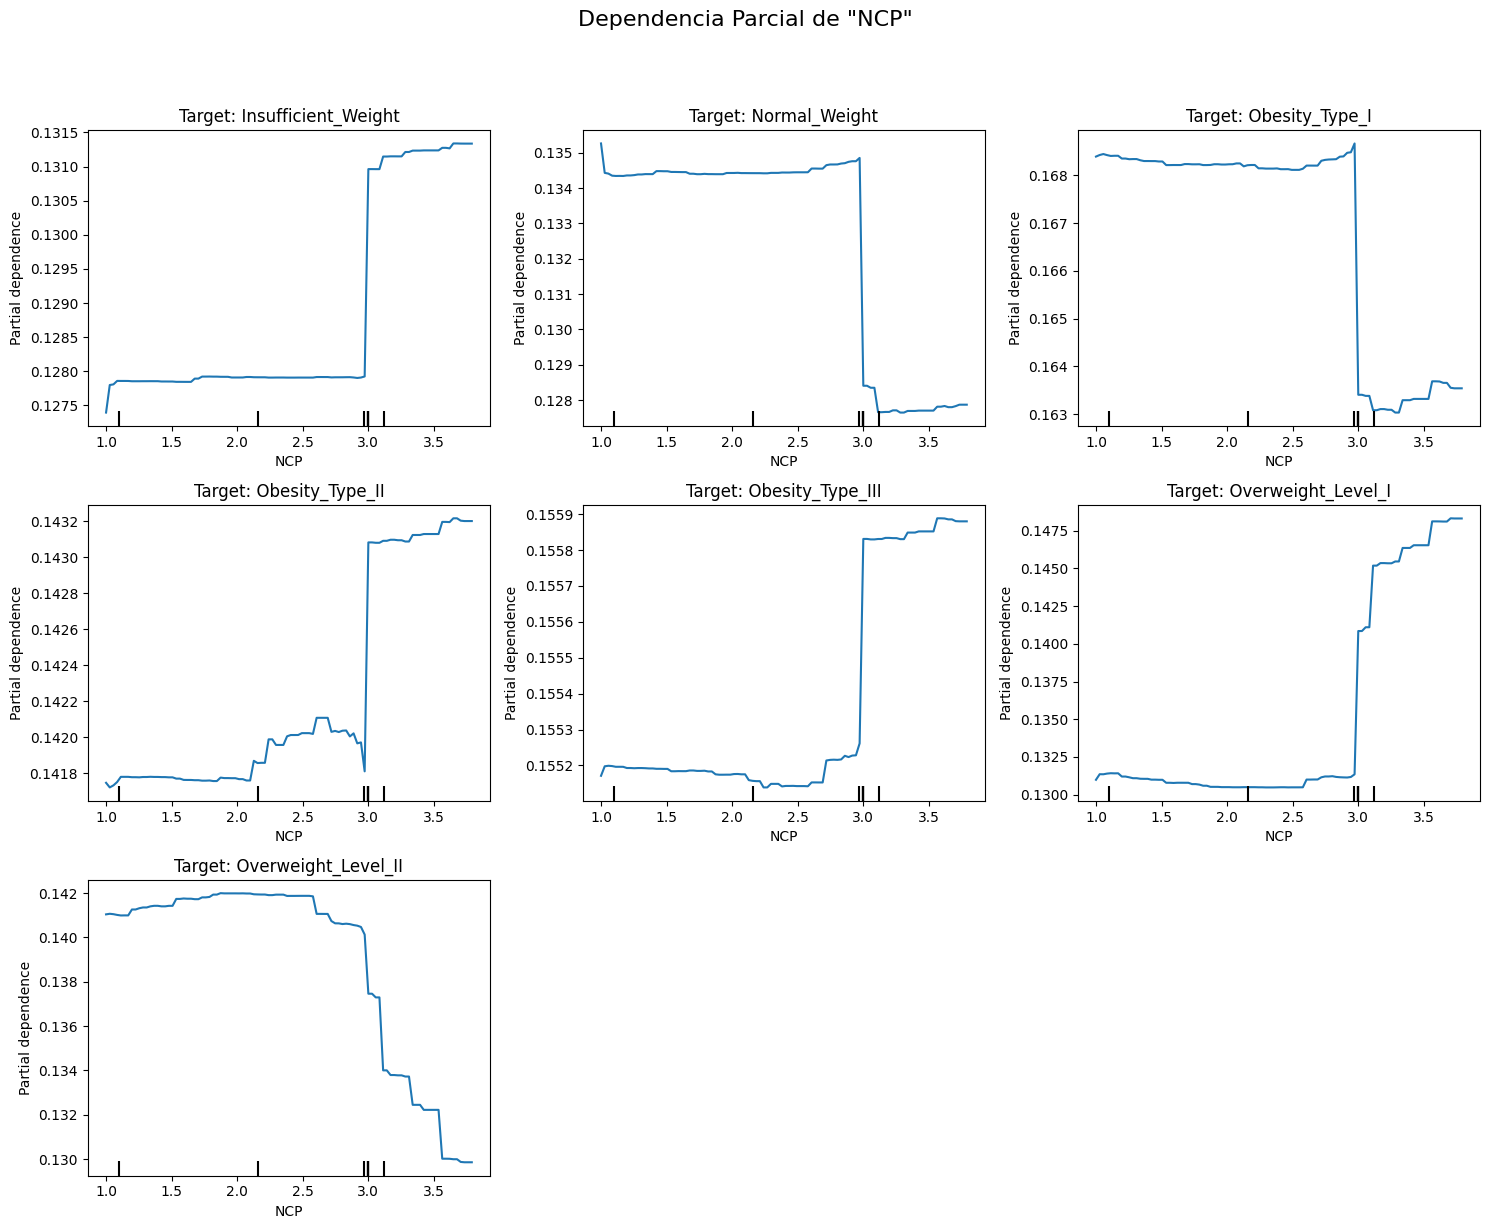

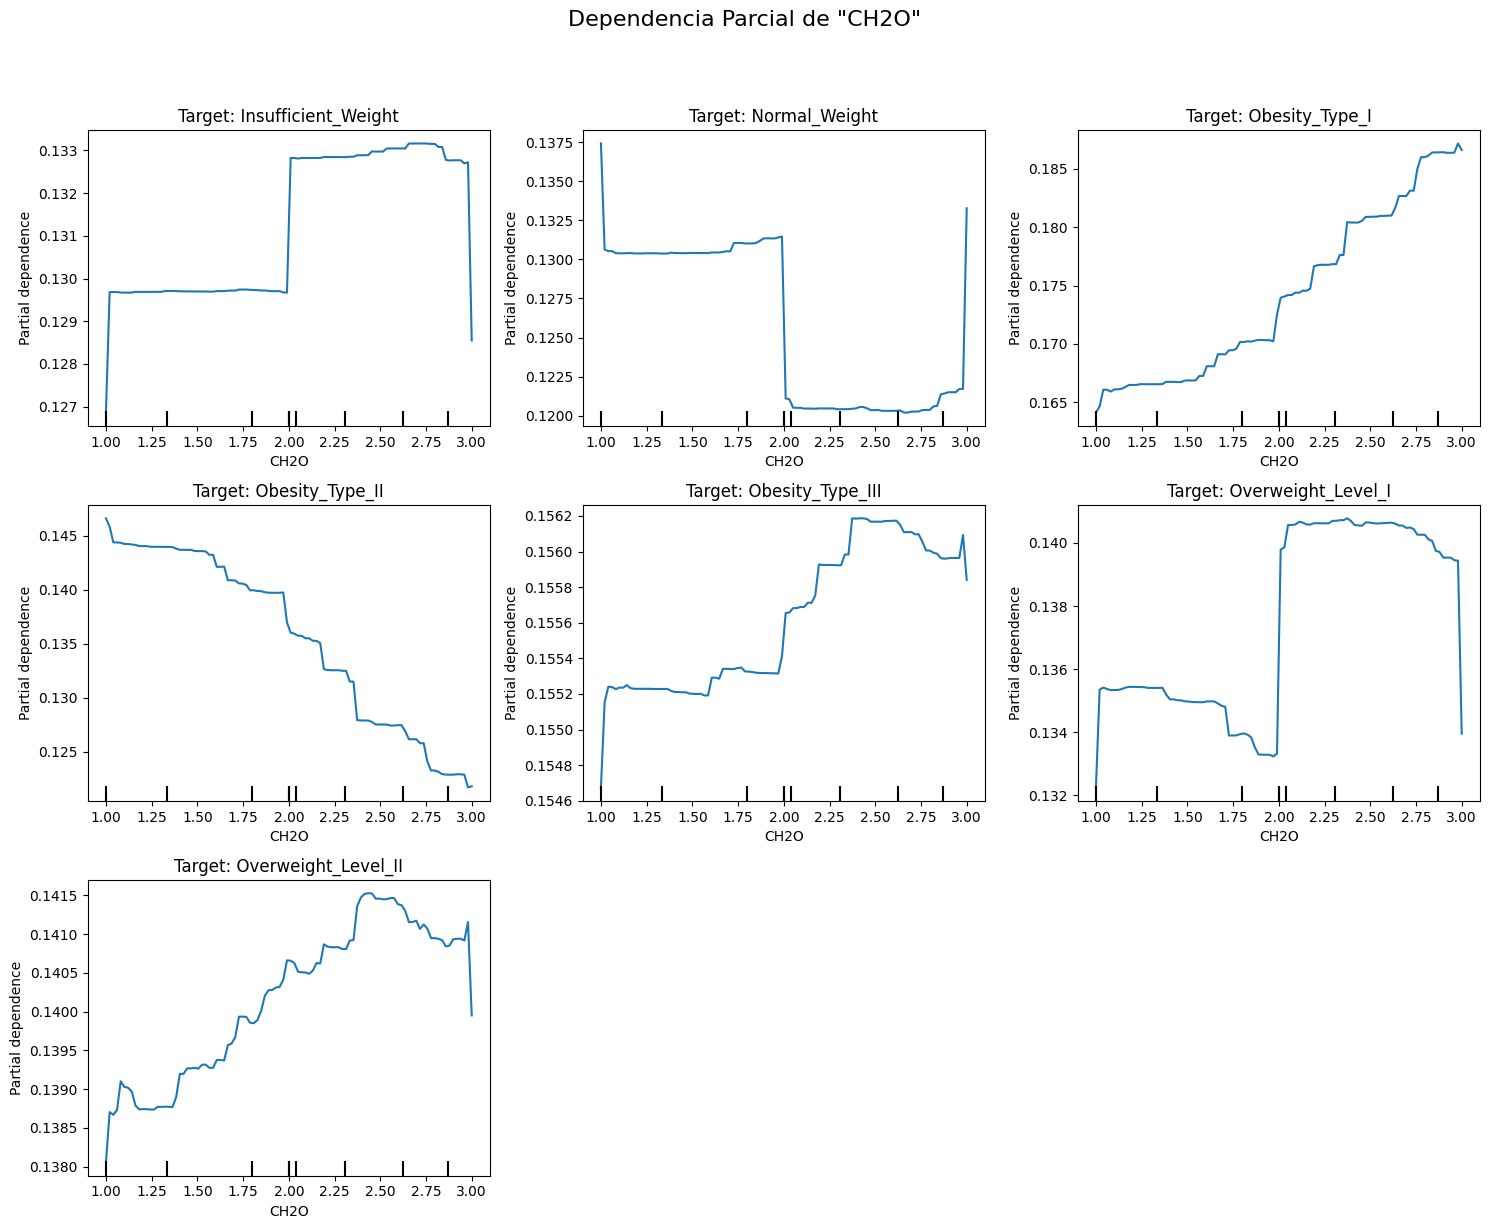

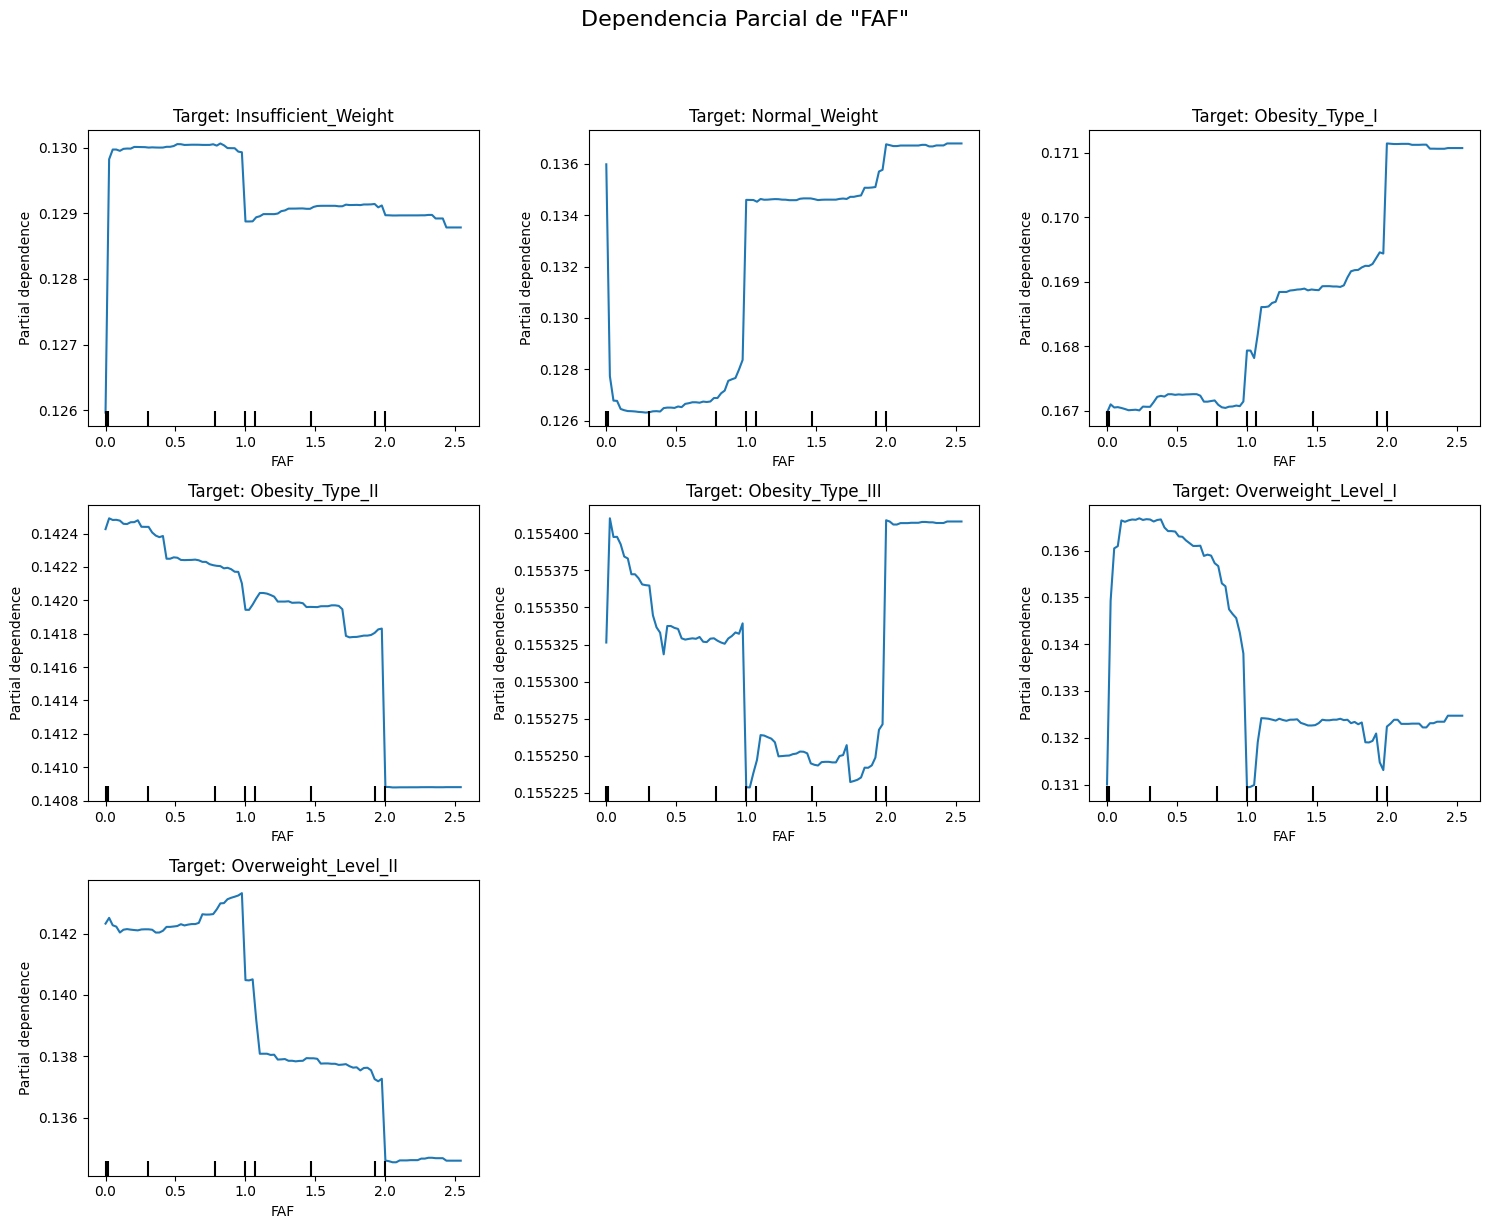

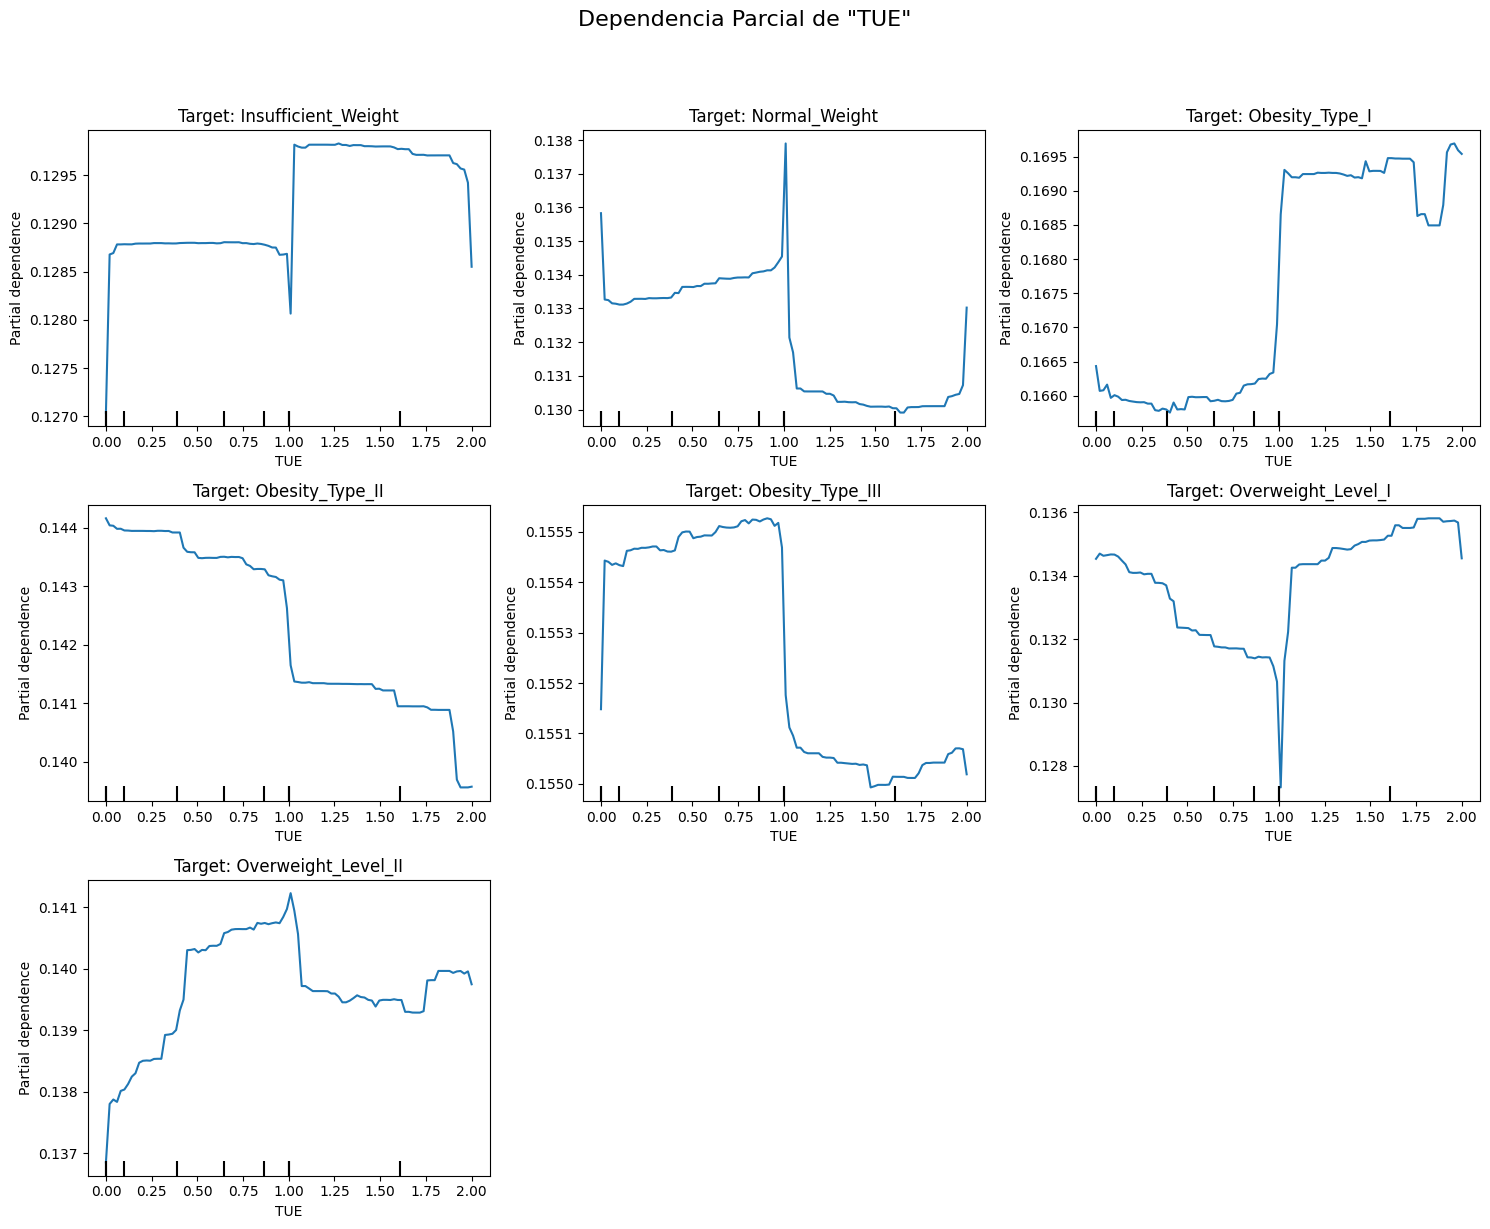

In [74]:
# =============================================================================
# 2. FUNCIONES DE ENTRENAMIENTO DE MODELOS
# =============================================================================

def create_preprocessor(X_train):
    """Crea un preprocesador de datos para variables numéricas y categóricas."""
    numeric_features = X_train.select_dtypes(include=np.number).columns
    categorical_features = X_train.select_dtypes(
        include=['object', 'category']
    ).columns

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=-20)),
        ('scaler', RobustScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
        ('onehot', OneHotEncoder(
            handle_unknown='ignore', sparse_output=False, drop='first'
        ))
    ])

    return ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ], remainder='passthrough')


def train_xgboost_with_tuning(X_train, y_train_encoded):
    """Entrena un modelo XGBoost con búsqueda de hiperparámetros."""
    preprocessor = create_preprocessor(X_train)
    
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(
            objective='multi:softmax', eval_metric='mlogloss',
            use_label_encoder=False, random_state=42
        ))
    ])

    param_grid = {
        'classifier__n_estimators': randint(100, 500),
        'classifier__max_depth': randint(3, 10),
        'classifier__learning_rate': uniform(0.01, 0.3),
        'classifier__subsample': uniform(0.6, 0.4),
        'classifier__colsample_bytree': uniform(0.6, 0.4),
    }

    random_search = RandomizedSearchCV(
        model_pipeline, param_distributions=param_grid, n_iter=50, cv=5,
        scoring='accuracy', verbose=1, random_state=42, n_jobs=-1
    )
    
    random_search.fit(X_train, y_train_encoded)
    return random_search


def train_random_forest_with_tuning(X_train, y_train_encoded):
    """Entrena un modelo Random Forest con búsqueda de hiperparámetros."""
    preprocessor = create_preprocessor(X_train)
    
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42))
    ])

    param_grid = {
        'classifier__n_estimators': randint(100, 500),
        'classifier__max_depth': randint(5, 30),
        'classifier__min_samples_split': randint(2, 20),
        'classifier__min_samples_leaf': randint(1, 20),
        'classifier__max_features': ['sqrt', 'log2'],
    }

    random_search = RandomizedSearchCV(
        model_pipeline, param_distributions=param_grid, n_iter=50, cv=5,
        scoring='accuracy', verbose=1, random_state=42, n_jobs=-1
    )
    
    random_search.fit(X_train, y_train_encoded)
    return random_search


def train_knn_with_tuning(X_train, y_train_encoded):
    """Entrena un modelo k-Nearest Neighbors con búsqueda de hiperparámetros."""
    preprocessor = create_preprocessor(X_train)
    
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier())
    ])

    param_grid = {
        'classifier__n_neighbors': randint(3, 31),
        'classifier__weights': ['uniform', 'distance'],
        'classifier__metric': ['euclidean', 'manhattan', 'minkowski'],
    }

    random_search = RandomizedSearchCV(
        model_pipeline, param_distributions=param_grid, n_iter=50, cv=5,
        scoring='accuracy', verbose=1, random_state=42, n_jobs=-1
    )
    
    random_search.fit(X_train, y_train_encoded)
    return random_search


# =============================================================================
# 3. FUNCIONES DE EVALUACIÓN E INTERPRETACIÓN
# =============================================================================

def evaluate_classification_model(best_model, X_test, y_test, y_test_encoded, le):
    """
    Genera y muestra las métricas de evaluación del modelo, incluyendo curvas
    ROC y de Precisión-Recall.
    """
    y_pred_encoded = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)
    y_pred_original = le.inverse_transform(y_pred_encoded)
    class_labels = le.classes_
    model_name = best_model.named_steps['classifier'].__class__.__name__

    # Reporte de Clasificación y Matriz de Confusión
    print("--- Reporte de Clasificación ---")
    print(classification_report(y_test, y_pred_original, target_names=class_labels))

    print("\n--- Matriz de Confusión ---")
    cm = confusion_matrix(y_test, y_pred_original, labels=class_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm, annot=True, fmt='g', cmap='Blues',
        xticklabels=class_labels, yticklabels=class_labels
    )
    plt.xlabel('Predicción'); plt.ylabel('Valor Real'); plt.title('Matriz de Confusión')
    plt.show()

    # ✨ CURVAS ROC y PR AÑADIDAS AQUÍ
    y_test_binarized = label_binarize(y_test_encoded, classes=range(len(class_labels)))
    n_classes = y_test_binarized.shape[1]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    fig.suptitle(f"Curvas de Evaluación para {model_name}", fontsize=16)

    # Curva ROC AUC
    roc_auc = roc_auc_score(y_test_binarized, y_pred_proba, multi_class='ovr')
    print(f"\nROC AUC Score (One-vs-Rest): {roc_auc:.4f}")
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
        ax1.plot(fpr, tpr, lw=2, label=f'{class_labels[i]} (AUC={auc(fpr, tpr):.2f})')
    ax1.plot([0, 1], [0, 1], 'k--', lw=2)
    ax1.set_xlabel('Tasa de Falsos Positivos (FPR)'); ax1.set_ylabel('Tasa de Verdaderos Positivos (TPR)')
    ax1.set_title('Curva ROC Multiclase (One-vs-Rest)'); ax1.legend(loc="lower right"); ax1.grid(True)

    # Curva Precisión-Recall
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(
            y_test_binarized[:, i], y_pred_proba[:, i]
        )
        ax2.plot(recall, precision, lw=2, label=f'Clase {class_labels[i]}')
    ax2.set_xlabel("Recall (Sensibilidad)"); ax2.set_ylabel("Precision")
    ax2.set_title("Curva Precisión-Recall Multiclase"); ax2.legend(loc="best"); ax2.grid(True)
    plt.show()


def plot_feature_importance(best_model, X_train):
    """Calcula y grafica la importancia de las variables del modelo."""
    if not hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
        print("\nEl modelo seleccionado (KNN) no tiene 'feature_importances_'.")
        return

    model = best_model.named_steps['classifier']
    preprocessor = best_model.named_steps['preprocessor']

    numeric_features = X_train.select_dtypes(include=np.number).columns
    cat_features = X_train.select_dtypes(include=['object', 'category']).columns
    ohe_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(cat_features)
    all_features = np.concatenate([numeric_features, ohe_features])

    importances_df = pd.DataFrame({
        'feature': all_features,
        'importance': model.feature_importances_
    }).sort_values(by='importance', ascending=False)

    plt.figure(figsize=(12, 10))
    sns.barplot(x='importance', y='feature', data=importances_df.head(20), palette='viridis')
    plt.title('Top 20 Variables más Importantes', fontsize=16)
    plt.xlabel('Importancia'); plt.ylabel('Variable'); plt.grid(axis='x', alpha=0.5)
    plt.show()


def plot_partial_dependence(best_model, X_train, features_to_plot, le):
    """
    Genera y muestra las curvas de dependencia parcial (PDP) para las
    variables especificadas.
    """
    class_labels = le.classes_
    print(f"\n--- Generando Curvas de Dependencia Parcial para: {features_to_plot} ---")

    for feature in features_to_plot:
        n_classes = len(class_labels)
        n_cols = 3
        n_rows = math.ceil(n_classes / n_cols)
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows), sharey=True)
        fig.suptitle(f'Dependencia Parcial de "{feature}"', fontsize=16, y=1.02)

        for i, class_name in enumerate(class_labels):
            ax = axes.flatten()[i]
            PartialDependenceDisplay.from_estimator(
                best_model,
                X_train,
                features=[feature],
                target=i,
                ax=ax
            )
            ax.set_title(f'Target: {class_name}')
            ax.set_xlabel(feature)
            ax.set_ylabel("Dependencia Parcial")

        for j in range(n_classes, len(axes.flatten())):
            axes.flatten()[j].axis('off')

        plt.tight_layout()
        plt.subplots_adjust(top=0.92)
        plt.show()


# =============================================================================
# 4. BLOQUE PRINCIPAL DE EJECUCIÓN
# =============================================================================
if __name__ == "__main__":

    # 1. Preparación de Datos
    TARGET = 'NObeyesdad'
    X = df.drop(TARGET, axis=1)
    y = df[TARGET]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    # 2. Diccionario de Modelos a Entrenar
    models_to_train = {
        "KNN": train_knn_with_tuning,
        "Random Forest": train_random_forest_with_tuning,
        "XGBoost": train_xgboost_with_tuning,
    }

    # 3. Bucle de Entrenamiento y Evaluación
    for model_name, training_function in models_to_train.items():
        print("="*80)
        print(f" ENTRENANDO MODELO: {model_name}")
        print("="*80)

        search_cv = training_function(X_train, y_train_encoded)
        best_model = search_cv.best_estimator_

        print("\n---  RESULTADOS ---")
        print(f"Mejores Hiperparámetros para {model_name}:")
        print(search_cv.best_params_)
        print(f"\nMejor puntaje CV (Accuracy): {search_cv.best_score_:.4f}")
        
        accuracy = best_model.score(X_test, y_test_encoded)
        print(f"Precisión final en Test: {accuracy:.4f}\n")

        print("\n--- EVALUACIÓN DETALLADA ---")
        evaluate_classification_model(
            best_model, X_test, y_test, y_test_encoded, label_encoder
        )

        print("\n---  INTERPRETACIÓN DEL MODELO ---")
        plot_feature_importance(best_model, X_train)

        if model_name == "XGBoost":
            print('Interpretacion adicional de la interaccion entre las variables y los resultados del modelo.')
            features_for_pdp = X_train.select_dtypes(include=np.number).columns.tolist()
            plot_partial_dependence(best_model, X_train, features_for_pdp, label_encoder)

# Conclusión y Selección del Modelo Final

---

###  Mejor Modelo: XGBoost

Tras un riguroso proceso de entrenamiento y optimización de hiperparámetros para tres algoritmos distintos (KNN, Random Forest y XGBoost), se ha determinado que el modelo **XGBoost es el que presenta el mejor rendimiento general**.

Esta selección se basa en la superioridad de sus métricas clave de evaluación:
* **Accuracy**: Obtuvo la mayor precisión en el conjunto de prueba.
* **ROC AUC Score**: Mostró el área bajo la curva más alta, indicando una mejor capacidad para discriminar entre las diferentes clases.
* **Curvas de Precisión-Recall**: Sus curvas dominaron a las de los otros modelos, demostrando un mejor balance entre precisión y exhaustividad (recall).

---

###  Interpretación del Modelo Ganador

Dado su rendimiento superior, se elige el modelo XGBoost para la fase final de interpretación. Para ahondar en su funcionamiento interno y entender cómo las variables influyen en las predicciones, se generarán **Curvas de Dependencia Parcial (PDP)**.

Estos gráficos nos permitirán analizar de forma desagregada cómo el cambio en una variable específica afecta la propensión (probabilidad) de que una observación sea clasificada en cada una de las categorías de obesidad.